# Introduction
Our client is the HR department at a large software company. They are rolling out a new initiative that they call "Proactive Retention."
The idea is to use data **to predict whether and employee is likely to leave**. Once these employees are identified, HR can be more proactive in reaching out to them before it's too late.

For this initiative, they only care about permanent (non-temp) employees.

Currently, their employee retention process is very retroactive. Once an employee leaves, he or she takes an "exit interview" and shares reasons for leaving. HR then tries to learn insights from that interview and make changes around the company accordingly. The HR department has hired us as data science consultants. They want to supplement their exit interviews with a more proactive approach.

**Requirement**
* Deliverable: Trained model file
* Model **interprtability** is very important
* Ouput Probabilities along with the prediction
* No latency constraints

# Data Loading and Data EDA

**Findings**
* There is one outlier with seniority = 98. The data point is dropped from analysis.
* Missing exists in variable quit_date, but the meaning of missing can be easily interpreted -- missing means the employee hasn't quit. Thus, the target varible, retention, is created.
* There is a moderate positive correlation between seniority and salary, which is reasonable and as expected. But neither of them has significant correlations with service_days.
* Based on feature engineering, a variable, service_days, was created.
* Overall, seniority is evenly distributed across company and department, with the only exception being company_id = 11 and 12, whose employees' seniorities are lower than the other companies. These two companies might be startups.
* Salary, on the other hand, varies across companies and departments. Employees at companies with company_id 1 and 2 have the highest average salaries, while those at companies with company_id 11 and 12 have the lowest. Department-wise, data science and engineering employees have the highest average salaries, whereas those in customer service have the lowest.
* **The average service_days across both companies and departments are pretty similar, around 450 days**. While the variance of service_days of company_id 11 and 12 are lower than that of the other companies, probabily because of the low employee numbers of the two companies.
* The retention rate seems doesn't vary much across companies and departments.

**Conclusions**
* The target variable (retention) is balanced. Thus, we will apply typical binary classification models to predict the retention rate.

## Environment Setting

In [2]:
# Print every output from a specific cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Change to the current location (ref: https://webapps.stackexchange.com/questions/170886/copy-the-path-of-a-file-in-google-drive)
import os
os.chdir('/content/drive/MyDrive/1 - Study Hard/Softwares and Coding/Python_ML/Dataset')
!pwd

/content/drive/MyDrive/1 - Study Hard/Softwares and Coding/Python_ML/Dataset


In [5]:
# Import relevant modules and load data file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

## Data Loading

In [6]:
inputfilename = 'Employee_Retention.csv'
data = pd.read_csv(inputfilename)

## Check Data Shape and Type

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   24702 non-null  int64  
 1   employee_id  24702 non-null  float64
 2   company_id   24702 non-null  int64  
 3   dept         24702 non-null  object 
 4   seniority    24702 non-null  int64  
 5   salary       24702 non-null  float64
 6   join_date    24702 non-null  object 
 7   quit_date    13510 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 1.5+ MB


In [ ]:
data.head()

,Unnamed: 0,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,2,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,3,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,4,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,5,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


employee_id should be integers. And it is the id variable.
company_id should be object.

In [7]:
data['employee_id'] = data['employee_id'].astype('int')
data['company_id'] = data['company_id'].astype('object')

In [8]:
data['employee_id'].duplicated().sum()

0

In [9]:
id_var = 'employee_id'

The column "Unnamed: 0" is clearly an index column containing no information. Let's remove it.

In [10]:
data.drop('Unnamed: 0', axis = 1, inplace = True)

## Check Missing Data

Column 'quit_date' contains missing data. It is easy to understand that missing means the employee is still working for the company.

Therefore, this column defines our target variable. Let's define it.

In [11]:
data['retention'] = np.where(data['quit_date'].isnull(), 1, 0)
target_var = 'retention'

## Check Duplicated Data

In [ ]:
data.duplicated().sum()

0

## Check Target Variable Distribution

In [ ]:
# the target var is pretty balanced
data['retention'].value_counts(normalize = True)

retention
0    0.546919
1    0.453081
Name: proportion, dtype: float64

In [ ]:
data.groupby('company_id')['retention'].value_counts(normalize = True)

company_id  retention
1           0            0.544544
            1            0.455456
2           0            0.522501
            1            0.477499
3           0            0.556930
            1            0.443070
4           0            0.559166
            1            0.440834
5           0            0.560114
            1            0.439886
6           0            0.551510
            1            0.448490
7           0            0.565359
            1            0.434641
8           0            0.553009
            1            0.446991
9           0            0.550468
            1            0.449532
10          0            0.554913
            1            0.445087
11          0            0.750000
            1            0.250000
12          0            0.500000
            1            0.500000
Name: proportion, dtype: float64

Rentention rates by company are pretty balanced except for company_id = 11.

## Feature Engineering

Both the join_date and quit_date have high cardinality and contain redundant information. Let's create more informative features out of them.
* service_days: the number of days the employee has/had been working for the company


In [12]:
# Since the max(join_date, quit_date) = 2015-12-10. Let's set the current_date as '2015-12-11'
data['quit_date'] = pd.to_datetime(data['quit_date'])
data['join_date'] = pd.to_datetime(data['join_date'])

In [13]:
data['service_days'] = (pd.to_datetime(np.where(data['quit_date'].isnull(), pd.to_datetime('2015-12-11'),
                                                    data['quit_date'])) - data['join_date']).dt.days.astype('int')

In [14]:
data['quit_date'] = data['quit_date'].dt.date
data['join_date'] = data['join_date'].dt.date

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee_id   24702 non-null  int64  
 1   company_id    24702 non-null  object 
 2   dept          24702 non-null  object 
 3   seniority     24702 non-null  int64  
 4   salary        24702 non-null  float64
 5   join_date     24702 non-null  object 
 6   quit_date     13510 non-null  object 
 7   retention     24702 non-null  int64  
 8   service_days  24702 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 1.7+ MB


In [ ]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,retention,service_days
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,0,585
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,0,340
2,927315,4,marketing,14,101000.0,2014-10-13,NaT,1,424
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,0,389
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,0,1040


## Train Test Split
We will only conduct data EDA on the training dataset to avoid infomation leakage.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data.loc[:, data.columns != target_var], data[target_var], test_size = 0.2, random_state = 0)

In [16]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19761 entries, 1675 to 2732
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee_id   19761 non-null  int64  
 1   company_id    19761 non-null  object 
 2   dept          19761 non-null  object 
 3   seniority     19761 non-null  int64  
 4   salary        19761 non-null  float64
 5   join_date     19761 non-null  object 
 6   quit_date     10807 non-null  object 
 7   service_days  19761 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 1.4+ MB


## Feature Distributions

In [17]:
train_df = x_train.copy()
train_df[target_var] = y_train
train_df = train_df.reset_index(drop = True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19761 entries, 0 to 19760
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee_id   19761 non-null  int64  
 1   company_id    19761 non-null  object 
 2   dept          19761 non-null  object 
 3   seniority     19761 non-null  int64  
 4   salary        19761 non-null  float64
 5   join_date     19761 non-null  object 
 6   quit_date     10807 non-null  object 
 7   service_days  19761 non-null  int64  
 8   retention     19761 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 1.4+ MB


In [18]:
test_df = x_test.copy()
test_df[target_var] = y_test
test_df = test_df.reset_index(drop = True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4941 entries, 0 to 4940
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee_id   4941 non-null   int64  
 1   company_id    4941 non-null   object 
 2   dept          4941 non-null   object 
 3   seniority     4941 non-null   int64  
 4   salary        4941 non-null   float64
 5   join_date     4941 non-null   object 
 6   quit_date     2703 non-null   object 
 7   service_days  4941 non-null   int64  
 8   retention     4941 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 347.5+ KB


In [19]:
# drop id_var, join_date and quit_date
train_df.drop([id_var, 'join_date', 'quit_date'], axis = 1, inplace = True)
test_df.drop([id_var, 'join_date', 'quit_date'], axis = 1, inplace = True)

In [ ]:
train_df.head()

,company_id,dept,seniority,salary,service_days,retention
0,1,marketing,27,202000.0,415,0.0
1,1,design,24,189000.0,339,0.0
2,10,sales,2,44000.0,627,0.0
3,1,data_science,20,285000.0,25,NaN
4,1,customer_service,24,117000.0,360,NaN


In [20]:
exclude_var = [target_var, id_var, 'join_date', 'quit_date']
num_vars = list(train_df.loc[:, ~train_df.columns.isin(exclude_var)].select_dtypes(exclude = ['object']).columns)
cat_vars = list(train_df.loc[:, ~train_df.columns.isin(exclude_var)].select_dtypes(include = ['object']).columns)

In [21]:
num_vars
cat_vars

['seniority', 'salary', 'service_days']

['company_id', 'dept']

### Numerical Features Distributions and Relationships
The following aspects of the data are studied in this section:
* Numerical feature densities
* Numerical features' pairwise relationships: scatter plot, Pearson/Spearman correlation coefficients

In [ ]:
train_df.describe()

,seniority,salary,service_days,retention
count,19761.000000,19761.000000,19761.000000,19761.000000
mean,14.158595,138054.703709,573.708567,0.453115
std,8.091240,75808.643961,361.494827,0.497810
min,1.000000,17000.000000,1.000000,0.000000
25%,7.000000,79000.000000,333.000000,0.000000
50%,14.000000,122000.000000,424.000000,0.000000
75%,21.000000,187000.000000,780.000000,1.000000
max,98.000000,408000.000000,1775.000000,1.000000


#### Ourlier Detection

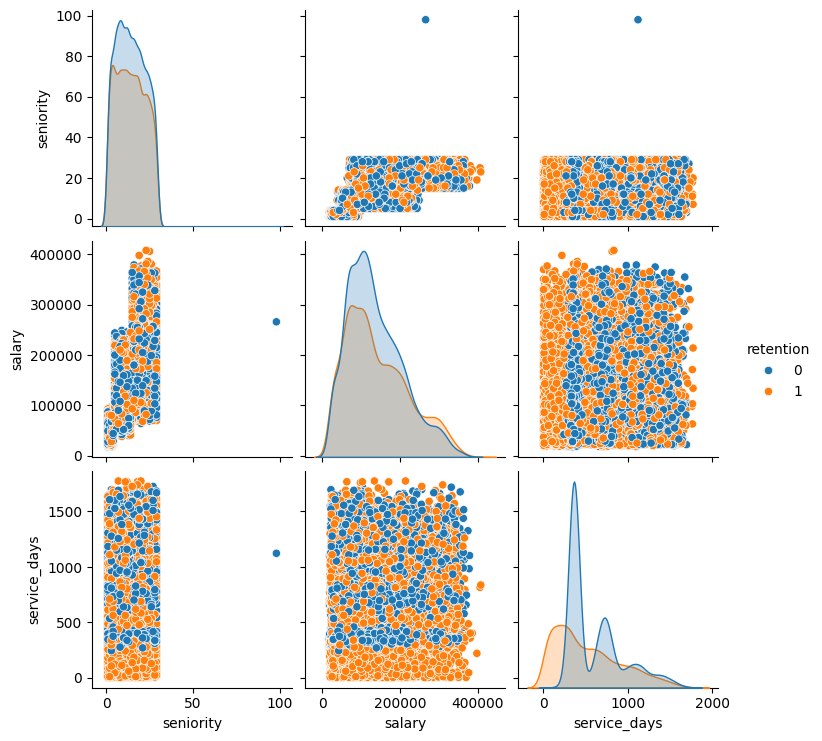

In [ ]:
sns.pairplot(train_df, vars = num_vars, hue = target_var);

In [ ]:
train_df[train_df['seniority'] == 98]

,company_id,dept,seniority,salary,service_days,retention
911,10,engineer,98,266000.0,1123,0


There is one obvious outlier: seniority > 50. Will remove the outlier.

In [22]:
train_df = train_df[train_df['seniority'] < 50]

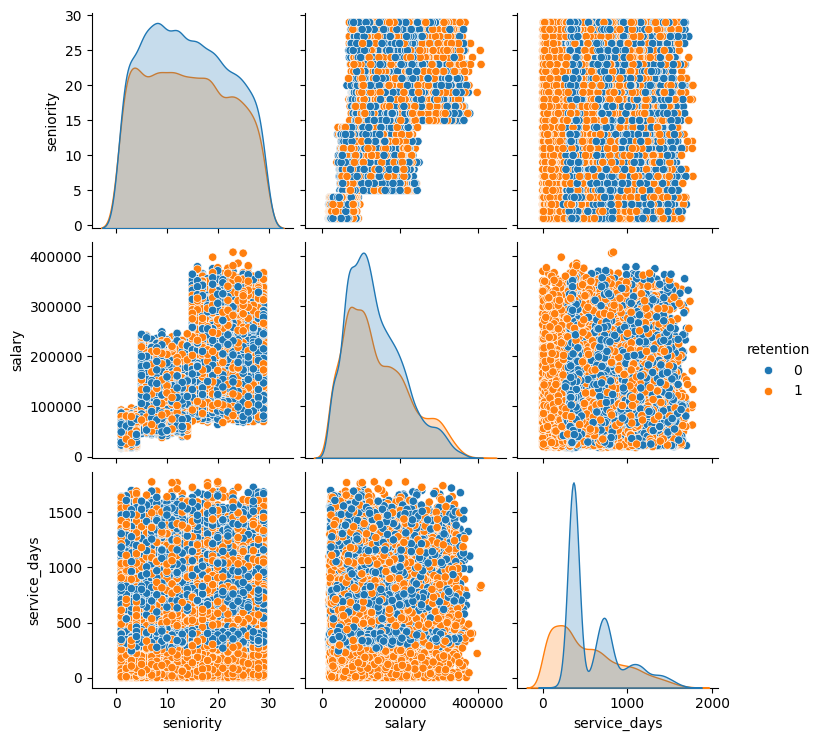

In [ ]:
sns.pairplot(train_df, vars = num_vars, hue = target_var);

As we can see from the density plot of service_days, there are two obvious peaks of employee departure.

In [ ]:
train_df[num_vars].corr(method='pearson')

,seniority,salary,service_days
seniority,1.000000,0.558491,0.002404
salary,0.558491,1.000000,0.051433
service_days,0.002404,0.051433,1.000000


In [ ]:
train_df[num_vars].corr(method='spearman')

,seniority,salary,service_days
seniority,1.000000,0.596745,0.003604
salary,0.596745,1.000000,0.028252
service_days,0.003604,0.028252,1.000000


There is a moderate positive relationship between seniority and salary, which is reasonable and as expected. But there is no correlation between service_days and the other two numerical variables.

### Categorical Features Distributions and Relationships
The following aspects of the data are studied in this section:
* Categorical features' frequency tables
* Categorical features' pairwise relationships: contingency tables, Chi-squared independence test

In [ ]:
cat_vars

['company_id', 'dept']

In [ ]:
for c in cat_vars:
  train_df[c].value_counts(normalize = True).sort_index()
  print('----------------')

company_id
1     0.342257
2     0.173026
3     0.111437
4     0.083249
5     0.072672
6     0.051974
7     0.048128
8     0.041953
9     0.038107
10    0.035476
11    0.000658
12    0.001063
Name: proportion, dtype: float64

----------------


dept
customer_service    0.371711
data_science        0.128543
design              0.055972
engineer            0.185172
marketing           0.127227
sales               0.131377
Name: proportion, dtype: float64

----------------


<Axes: xlabel='company_id'>

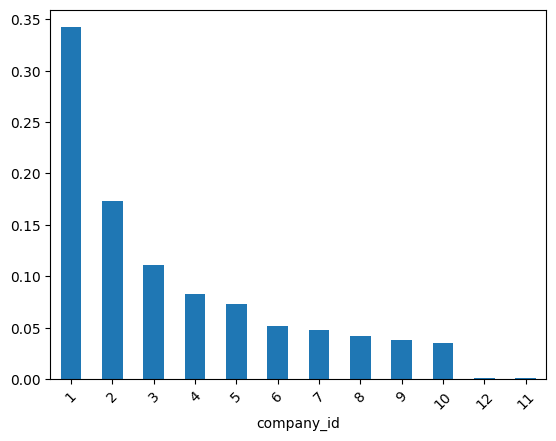

<Axes: xlabel='dept'>

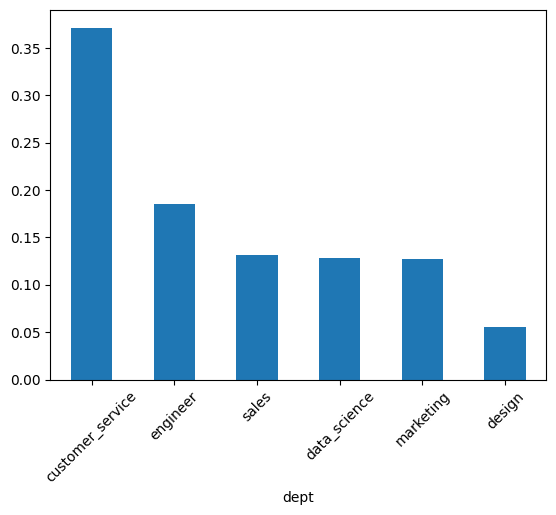

In [ ]:
for cv in cat_vars:
    train_df[cv].value_counts(normalize=True).plot(kind="bar", rot = 45)
    plt.show()

### Numerical Features v.s. Categorical Features Relationships
The following aspects of the data are studied in this section:
* Numerical feature distributions (in boxplot) by levels of categorical features
* *If necessary, we can also perform statistical tests (z/t-test; ANOVA) to get the corresponding statistical significance

<Axes: title={'center': 'seniority'}, xlabel='company_id'>

Text(0.5, 1.0, 'Boxplot of seniority grouped by company_id')

Text(0.5, 0.98, '')

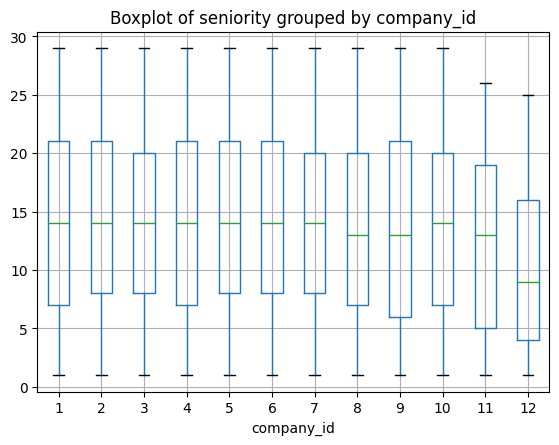

<Axes: title={'center': 'seniority'}, xlabel='dept'>

Text(0.5, 1.0, 'Boxplot of seniority grouped by dept')

Text(0.5, 0.98, '')

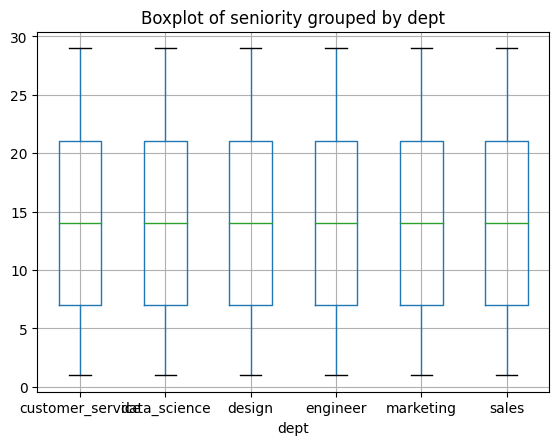

<Axes: title={'center': 'salary'}, xlabel='company_id'>

Text(0.5, 1.0, 'Boxplot of salary grouped by company_id')

Text(0.5, 0.98, '')

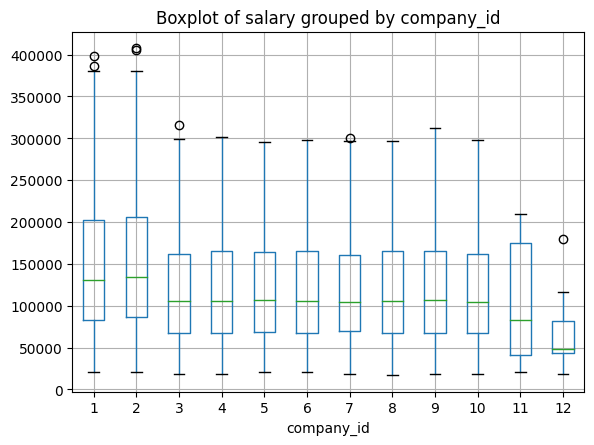

<Axes: title={'center': 'salary'}, xlabel='dept'>

Text(0.5, 1.0, 'Boxplot of salary grouped by dept')

Text(0.5, 0.98, '')

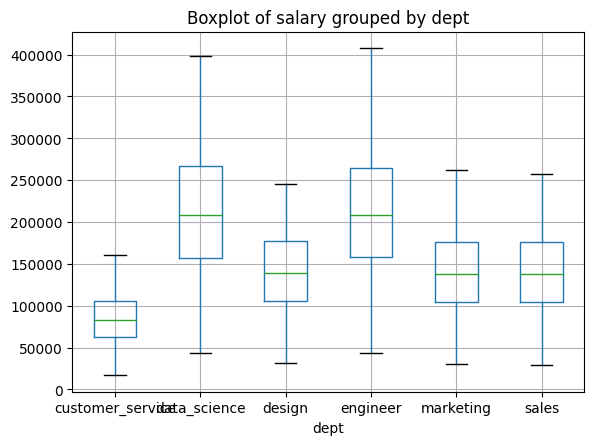

<Axes: title={'center': 'service_days'}, xlabel='company_id'>

Text(0.5, 1.0, 'Boxplot of service_days grouped by company_id')

Text(0.5, 0.98, '')

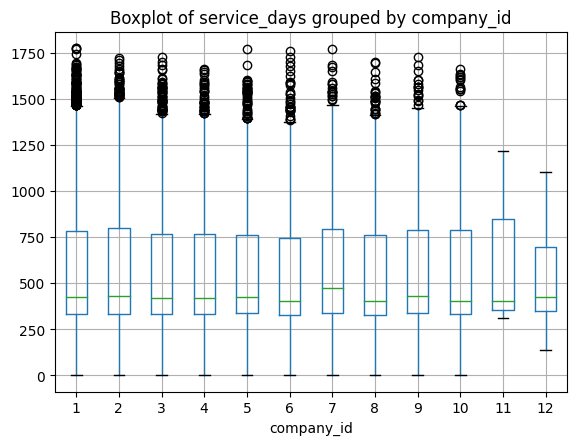

<Axes: title={'center': 'service_days'}, xlabel='dept'>

Text(0.5, 1.0, 'Boxplot of service_days grouped by dept')

Text(0.5, 0.98, '')

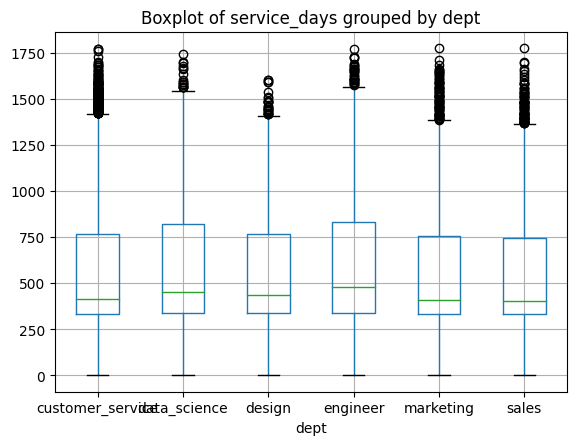

In [ ]:
import matplotlib.pyplot as plt

for nv in num_vars:
  for cv in cat_vars:
    train_df.boxplot(column = nv, by = cv)
    plt.title(f'Boxplot of {nv} grouped by {cv}')
    plt.suptitle('')  # turn off the default title
    plt.show()


**Conclusion**:
* We can see that overall seniority is pretty evenly distributed across company and department, with the only exception being company_id = 11 and 12, whose employees' seniorities are lower than the other companies.
* Salary, on the other hand, varies across companies and departments. Employees at companies with company_id 1 and 2 have the highest average salaries, while those at companies with company_id 11 and 12 have the lowest. Department-wise, data science and engineering employees have the highest average salaries, whereas those in customer service have the lowest.
* **The average service_days across both companies and departments are pretty similar, around 450 days**. While the variance of service_days of company_id 11 and 12 are lower than that of the other companies, probabily because of the low employee numbers of the two companies.



### Features v.s. Target Variable Relationships
We will examine
* Boxplot of numerical variables by levels of target variable
* Mean target variable (retention rate) by numerical variables [can skip if plan to compute SHAP values later]


<Axes: xlabel='retention', ylabel='seniority'>

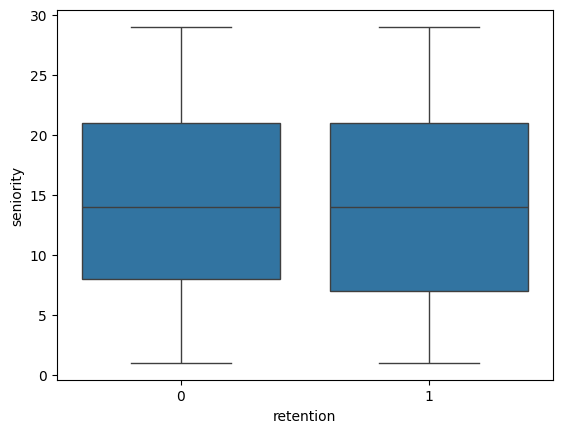

<Axes: xlabel='retention', ylabel='salary'>

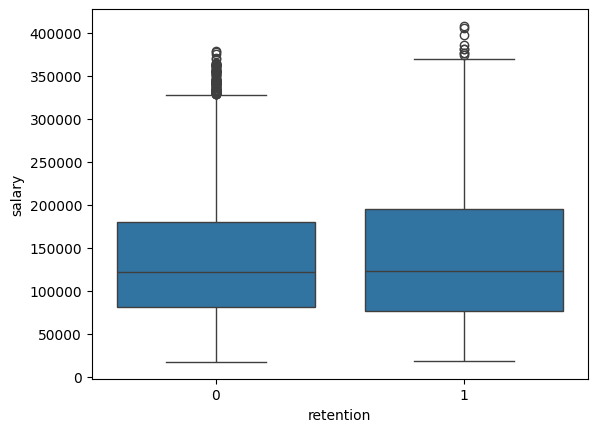

In [ ]:
# Boxplot of numerical variables by levels of target variable
for x in num_vars:
  sns.boxplot(train_df, x = train_df[target_var], y = train_df[x])
  plt.show()

<Axes: xlabel='seniority'>

Text(0.5, 1.0, 'retention by seniority')

Text(0, 0.5, 'retention Rate')

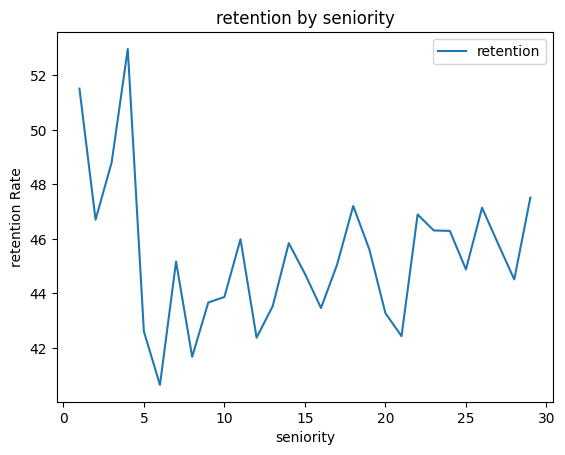

In [ ]:
# retention rate vs. seniority
grp_cvr = train_df.groupby(num_vars[0],as_index = False)[target_var].mean()
grp_cvr[target_var] *= 100
grp_cvr.plot(x = num_vars[0], y = target_var)
plt.title(f'{target_var} by {num_vars[0]}')
plt.ylabel(f'{target_var} Rate')

We can see that there is a sharp decline in retention rate around seniority = 5 years. After that, retention rate graduately increases as seniority increases.

<Axes: xlabel='salary'>

Text(0.5, 1.0, 'retention by salary')

Text(0, 0.5, 'retention Rate')

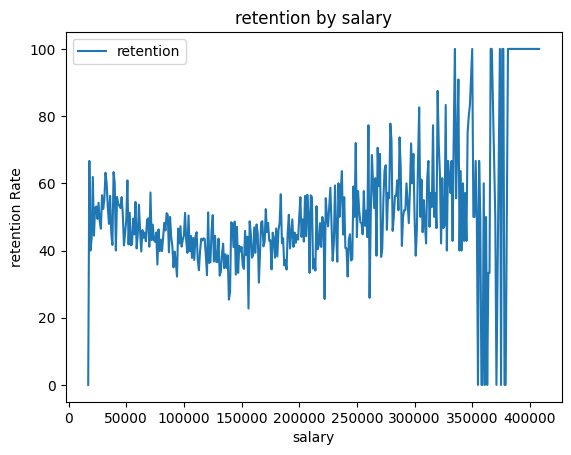

In [ ]:
# retention rate vs. salary
grp_cvr = train_df.groupby(num_vars[1],as_index = False)[target_var].mean()
grp_cvr[target_var] *= 100
grp_cvr.plot(x = num_vars[1], y = target_var)
plt.title(f'{target_var} by {num_vars[1]}')
plt.ylabel(f'{target_var} Rate')

<Axes: xlabel='service_days'>

Text(0.5, 1.0, 'retention by salary')

Text(0, 0.5, 'retention Rate')

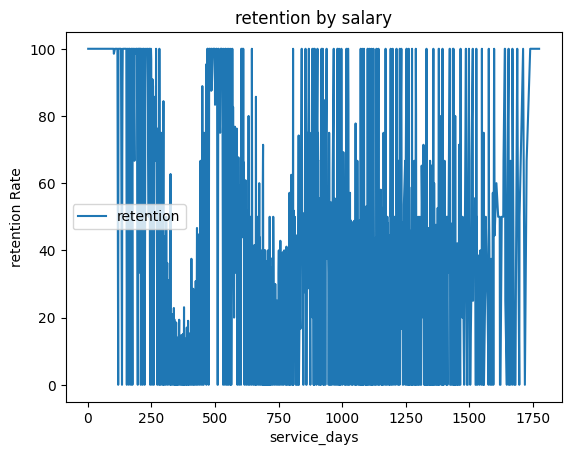

In [ ]:
# retention rate vs. service_days
grp_cvr = train_df.groupby(num_vars[2],as_index = False)[target_var].mean()
grp_cvr[target_var] *= 100
grp_cvr.plot(x = num_vars[2], y = target_var)
plt.title(f'{target_var} by {num_vars[2]}')
plt.ylabel(f'{target_var} Rate')

The plot is too noisy. Let's conduct binning on service_days to reduce noise.

In [ ]:
train_df_copy = train_df.copy()
train_df_copy['serv_days_bin'] = pd.cut(train_df[num_vars[2]], bins = 50)

<Axes: xlabel='serv_days_bin'>

Text(0.5, 1.0, 'retention by serv_days_bin')

Text(0, 0.5, 'retention Rate')

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]),
 [Text(-10.0, 0, '(1420.2, 1455.68]'),
  Text(0.0, 0, '(-0.774, 36.48]'),
  Text(10.0, 0, '(355.8, 391.28]'),
  Text(20.0, 0, '(710.6, 746.08]'),
  Text(30.0, 0, '(1065.4, 1100.88]'),
  Text(40.0, 0, '(1420.2, 1455.68]'),
  Text(50.0, 0, ''),
  Text(60.0, 0, '')])

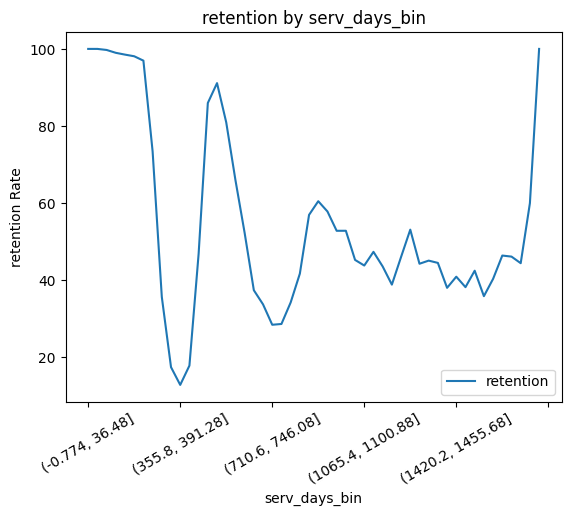

In [ ]:
grp_cvr = train_df_copy.groupby('serv_days_bin',as_index = False)[target_var].mean()
grp_cvr[target_var] *= 100
grp_cvr.plot(x = 'serv_days_bin', y = target_var)
plt.title(f'{target_var} by serv_days_bin')
plt.ylabel(f'{target_var} Rate')
plt.xticks(rotation=30)

In [ ]:
for cv in cat_vars:
  cat_var_pairwise_relationship(train_df, cv, target_var)
  print('----------------')

The contingency table of company_id and retention is
retention          0         1
company_id                    
1           0.544433  0.455567
2           0.519450  0.480550
3           0.559037  0.440963
4           0.559271  0.440729
5           0.566156  0.433844
6           0.546251  0.453749
7           0.577287  0.422713
8           0.552473  0.447527
9           0.543161  0.456839
10          0.553495  0.446505
11          0.692308  0.307692
12          0.476190  0.523810
----------------------------------------------
The p value of Chisq independence test is: 1.0. The test is NOT significant
----------------
The contingency table of dept and retention is
retention                0         1
dept                                
customer_service  0.554799  0.445201
data_science      0.531496  0.468504
design            0.560579  0.439421
engineer          0.512162  0.487838
marketing         0.563644  0.436356
sales             0.566256  0.433744
------------------------------

<Axes: xlabel='company_id', ylabel='retention'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

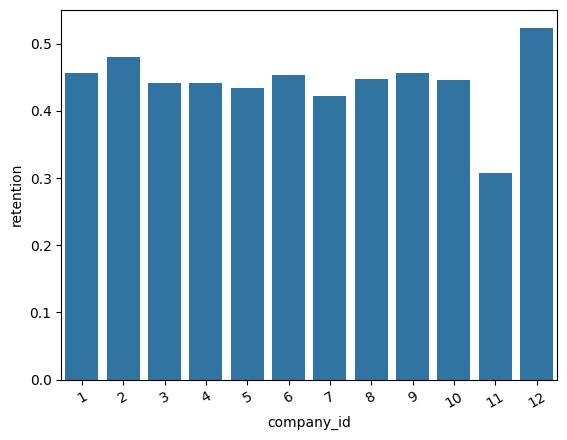

<Axes: xlabel='dept', ylabel='retention'>

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'customer_service'),
  Text(1, 0, 'data_science'),
  Text(2, 0, 'design'),
  Text(3, 0, 'engineer'),
  Text(4, 0, 'marketing'),
  Text(5, 0, 'sales')])

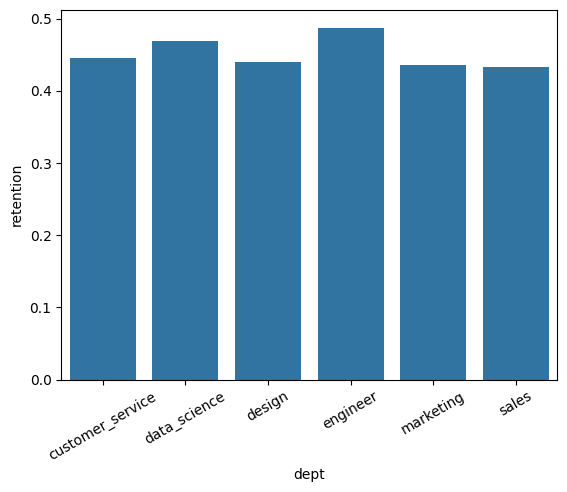

In [ ]:
for c in cat_vars:
  sns.barplot(train_df.groupby([c])[target_var].mean())
  plt.xticks(rotation=30)
  plt.show();

The retention rate seems doesn't vary much across companies and departments.

# Modeling
For this retention rate prediction problem, we will fit three binary classification models, namely, Logistic Regression, Random Forest, and XGBoost.
* For each model, we will apply grid search cross-validation on the training data to select the optimal set of hyperparameters.
* Each model will then be trained on the entire training dataset using these optimal hyperparameters.
* The model with the best performance will be selected as the final model.
* Finally, the selected model will be evaluated on the testing dataset to assess its generalization performance.

since the target variable is balanced, we will use accuracy and ROC AUC as the model selection criteria.

In [26]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve

## Preprocessing
Below, we apply
* one-hot encoding on the categorical features
* standarization on numerical features (helps the fitting algorithm converge faster).

In [27]:
# pd.get_dummies() will automately detect categorical variables and apply one-hot encodings on them. Thus, can pass the entire dataset to it.

train_df_pp = pd.get_dummies(train_df, dtype = int)
test_df_pp = pd.get_dummies(test_df, dtype = int)

In [28]:
sc = StandardScaler()
train_df_pp[num_vars] = sc.fit_transform(train_df_pp[num_vars])
test_df_pp[num_vars] = sc.transform(test_df_pp[num_vars])

In [29]:
X_train = train_df_pp.loc[:, train_df_pp.columns != target_var]
y_train = train_df_pp[target_var]

X_test = test_df_pp.loc[:, test_df_pp.columns != target_var]
y_test = test_df_pp[target_var]

In [ ]:
X_train.head()

,seniority,salary,service_days,company_id_1,company_id_2,company_id_3,company_id_4,company_id_5,company_id_6,company_id_7,...,company_id_9,company_id_10,company_id_11,company_id_12,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,1.591931,0.843656,-0.438983,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1.220148,0.672159,-0.649233,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-1.506260,-1.240690,0.147505,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.724437,1.938596,-1.517900,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1.220148,-0.277669,-0.591138,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [30]:
def training_pipeline(X_train, y_train, estimator, param, metric = 'accuracy', cv = 5, refit = True, return_train_score = True):
  gs = GridSearchCV(estimator = estimator,
                      param_grid = param,
                      scoring = metric,
                      cv = cv,
                      refit = refit,
                      return_train_score = return_train_score)
  gs.fit(X_train, y_train)

  res = {}


  res['fitted_model'] = gs.best_estimator_

  # Best set of hyperparameters
  res['best_params_'] = gs.best_params_

  # For logistic regression, also return the fitted coefficient under the best set of hyperparameters
  if 'LogisticRegression' in str(estimator):
    fitted_gs = gs.best_estimator_
    fitted_coef = {list(X_train.columns)[i]: np.round(fitted_gs.coef_[0][i],2) for i in range(len(list(X_train.columns)))}
    fitted_coef['intercept'] = np.round(fitted_gs.intercept_[0], 2)
    res['fitted_coef'] = fitted_coef

  # Mean cross-validated score of the best_estimator
  res['best_score'] = gs.best_score_

  return res


## Logistic Regression

In [ ]:
lr_est = LogisticRegression(random_state = 0,
                            C = 0.001,
                            penalty = 'l2',
                             tol = 1e-05,
                             max_iter = 100,
                            solver='lbfgs'
                            )

lr_param = {
     'C':[0.000001, 0.00001, 0.0001, 0.001]
    # 'max_iter' : [100, 200, 300],
    # 'tol' : [1e-05,1e-04, 1e-03, 1e-02]
    }
lr_res = training_pipeline(X_train, y_train, lr_est, lr_param)

In [ ]:
lr_res['best_params_']

{'C': 0.001}

In [ ]:
lr_res['best_score']

0.6239878542510122

In [ ]:
lr_res['fitted_coef']

{'seniority': -0.05,
 'salary': 0.09,
 'service_days': -0.2,
 'company_id_1': 0.0,
 'company_id_2': 0.05,
 'company_id_3': -0.01,
 'company_id_4': -0.01,
 'company_id_5': -0.01,
 'company_id_6': 0.0,
 'company_id_7': -0.02,
 'company_id_8': -0.0,
 'company_id_9': 0.01,
 'company_id_10': -0.0,
 'company_id_11': -0.0,
 'company_id_12': 0.0,
 'dept_customer_service': 0.02,
 'dept_data_science': 0.0,
 'dept_design': -0.01,
 'dept_engineer': 0.04,
 'dept_marketing': -0.03,
 'dept_sales': -0.03,
 'intercept': -0.2}

In [ ]:
# precision, recall, f1-score
ytrain_pred = lr_res['fitted_model'].predict(X_train)
print(classification_report(y_true = y_train, y_pred = ytrain_pred)) # Should look at the result of class 1

              precision    recall  f1-score   support

           0       0.60      0.91      0.73     10806
           1       0.73      0.28      0.40      8954

    accuracy                           0.63     19760
   macro avg       0.67      0.60      0.57     19760
weighted avg       0.66      0.63      0.58     19760



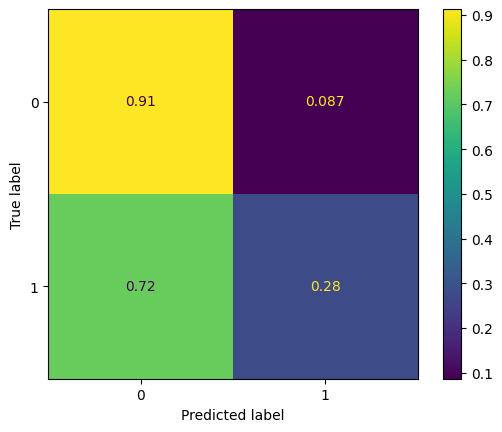

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_train, ytrain_pred, normalize = 'true', labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()

The false negative rate (classify retention as non-retention) is too high, probably because non-linear relationship exist between features and the target variable. Let's try ML models that can capture non-linear relationships below, namely, Random Forest and XGBoost.

Text(0.5, 1.0, 'ROC of Logistic Regression')

(-0.1, 1.1)

(-0.1, 1.1)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

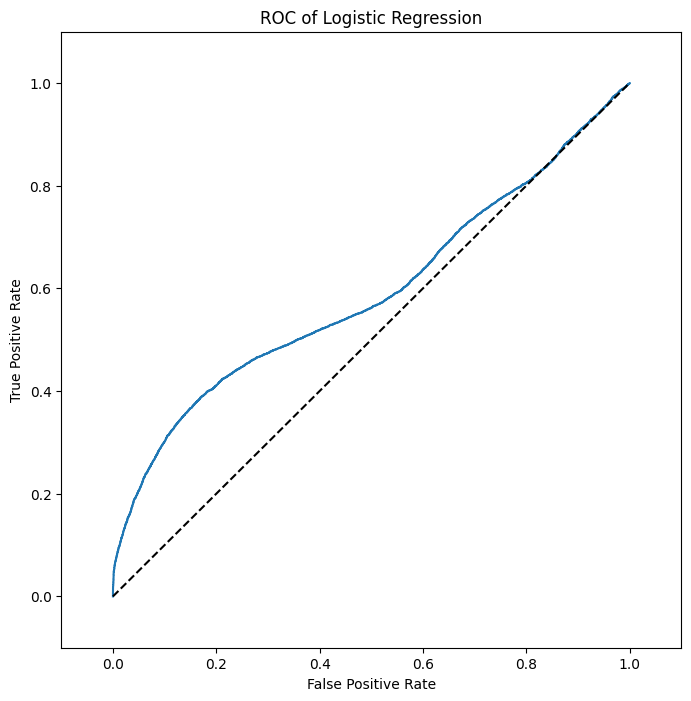

In [ ]:
y_pred_proba = lr_res['fitted_model'].predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('ROC of Logistic Regression')

# Plot ROC curve
plt.plot(fpr, tpr)

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The ROC curve is pretty bad

## Random Forest
For random forest, one-hot encoding tends to result in sparse trees. So, we will apply lable encoding to string-coding categorical variables.

In [33]:
# Select string-coding categorical variables
ind = (train_df.applymap(type) == str).all(0)
col = train_df.columns[ind].values[0] if len(train_df.columns[ind].values) == 1 else train_df.columns[ind].values

In [34]:
# Apply Label encoder to the string variable: 'dept'
le = LabelEncoder()
train_df_le = train_df.copy()
test_df_le = test_df.copy()
train_df_le[col] = le.fit_transform(train_df_le[col])
test_df_le[col] = le.transform(test_df_le[col])

In [35]:
X_train_rf = train_df_le.loc[:, train_df_le.columns != target_var]
y_train_rf = train_df_le[target_var]

X_test_rf = test_df_le.loc[:, test_df_le.columns != target_var]
y_test_rf = test_df_le[target_var]

In [ ]:
rf_est = RandomForestClassifier(random_state = 0,
                                n_estimators = 200, # number of trees in the forest. Increasing doesn't yield a better res
                                max_depth = None, # default is None
                                criterion = 'entropy',
                                 max_features = 'sqrt', # rule_of_thumb for classification problems
                                  min_samples_split = 2, # default is 2
                                  min_samples_leaf = 5, # default is 1
                                ccp_alpha = 0.001 # pruning parameter， higher value prunes deeper. pruning doesn't yield a better res in this case
                                )

rf_param = {
    #  'min_samples_split':[2,3,4],
    #  'min_samples_leaf':[4,5,
# 'n_estimators':[100,200,300]
}

rf_res = training_pipeline(X_train_rf, y_train_rf, rf_est, rf_param, metric = 'roc_auc')

In [ ]:
rf_res['best_params_']

{}

In [ ]:
rf_res['best_score']

0.8179625842034609

In [ ]:
# classification_report of precision, recall, f1-score
ytrain_pred = rf_res['fitted_model'].predict(X_train_rf)
print(classification_report(y_true = y_train_rf, y_pred = ytrain_pred)) # Should look at the result of class 1

              precision    recall  f1-score   support

           0       0.70      0.93      0.80     10806
           1       0.86      0.52      0.65      8954

    accuracy                           0.74     19760
   macro avg       0.78      0.72      0.72     19760
weighted avg       0.77      0.74      0.73     19760



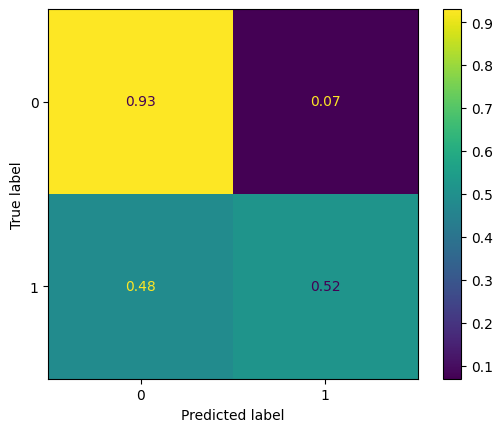

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_train, ytrain_pred, normalize = 'true', labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1])
disp.plot()

The confusion matrix under RF looks much better than that under LR.

Text(0.5, 1.0, 'ROC of Random Forest')

(-0.1, 1.1)

(-0.1, 1.1)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

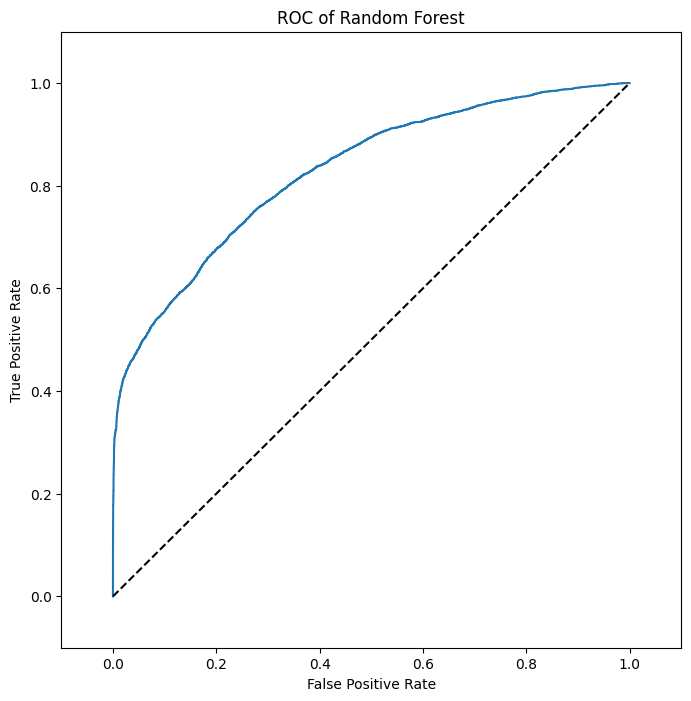

In [ ]:
y_pred_proba = rf_res['fitted_model'].predict_proba(X_train_rf)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('ROC of Random Forest')

# Plot ROC curve
plt.plot(fpr, tpr)

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Axes: xlabel='feature_imp', ylabel='feature'>

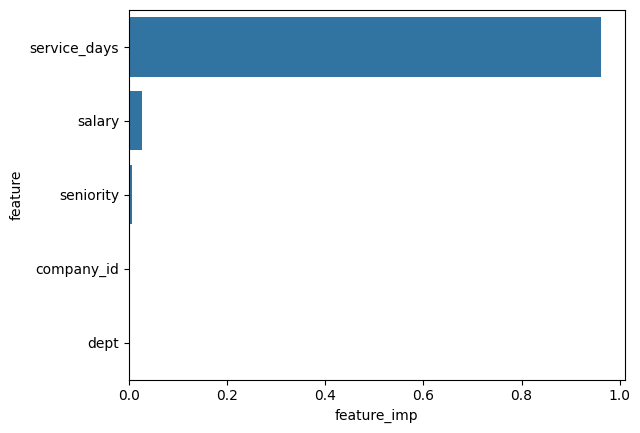

In [ ]:
# The feature importance here is Gini importance: (normalized) total reduction of the criterion brought by that feature.
# Since the features are not highly correlated, feature importances can be correctly interpreted.

imp = rf_res['fitted_model'].feature_importances_
imp_df = pd.DataFrame({'feature_imp': imp, 'feature': list(X_train_rf.columns)}).sort_values(by = ['feature_imp'], ascending = False)
sns.barplot(x = imp_df['feature_imp'], y = imp_df['feature'])

## XGBoost
Tuning reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

[API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
* First tune: **max_depth** and **min_child_weight** have the highest impact on the performance
* Then tune: regularization parameters: **reg_lambda, alpha, colsample_bytree, subsample**
* Last tune: tune learning rate, **eta** and **n_estimators** with the rest of the hyperparameter fixed at their best values

In [36]:
X_train_xgb = X_train_rf.copy()
X_train_xgb[cat_vars] = X_train_xgb[cat_vars].astype('category') # need to set object columns to category in order to use the  enable_categorical=True feature

In [37]:
X_test_xgb = X_test_rf.copy()
X_test_xgb[cat_vars] = X_test_xgb[cat_vars].astype('category')

In [38]:
xgb_est = xgb.XGBClassifier(random_state = 0,
                            objective = 'binary:logistic',
                             n_estimators = 100,
                             eta = 0.1, # learning_rate/step size shrinkage
                              max_depth = 4,  # default = 6
                              min_child_weight = 2, # Minimum sum of instance weight(hessian) needed in a child.
                              reg_lambda = 1, # L2 regularization para
                              alpha = 0.8, # L1 regularization para, default = 0. Not using here since feature dim is not high
                              colsample_bytree = 1,  # feature random sampling fraction for each tree
                           subsample = 1, # data random sampling fraction for each tree
                           importance_type = 'gain',
                           enable_categorical=True
                            )


xgb_param = {
        # 'eta': [ 0.1, 0.2]
        # 'n_estimators':[100, 200, 300]
        # 'max_depth': [3,4,5],
        # 'min_child_weight':[1,2,3]
        # 'reg_lambda': [1,1.5,2],
        # 'alpha': [0.7, 0.8]
        # 'colsample_bytree':[0.9, 1]
        #  'subsample': [0.6, 0.8, 1]
      }

xgb_res = training_pipeline(X_train_xgb, y_train, xgb_est, xgb_param, metric = 'roc_auc')

In [ ]:
xgb_res['best_params_']

{}

In [39]:
xgb_res['best_score']

0.8256601996000811

In [ ]:
# classification_report of precision, recall, f1-score
ytrain_pred = xgb_res['fitted_model'].predict(X_train_xgb)
print(classification_report(y_true = y_train, y_pred = ytrain_pred)) # Should look at the result of class 1

              precision    recall  f1-score   support

           0       0.73      0.88      0.80     10806
           1       0.81      0.61      0.70      8954

    accuracy                           0.76     19760
   macro avg       0.77      0.75      0.75     19760
weighted avg       0.77      0.76      0.75     19760



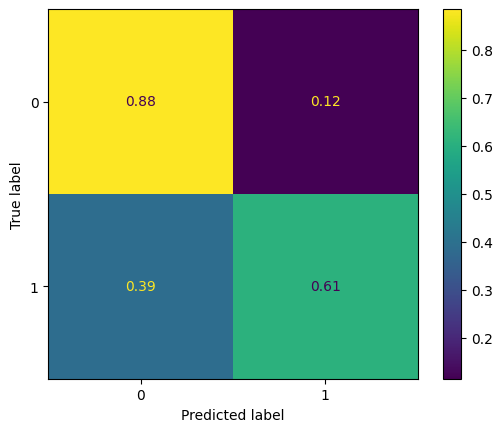

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_train, ytrain_pred, normalize = 'true', labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1])
disp.plot()

Text(0.5, 1.0, 'ROC of XGBoost')

(-0.1, 1.1)

(-0.1, 1.1)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

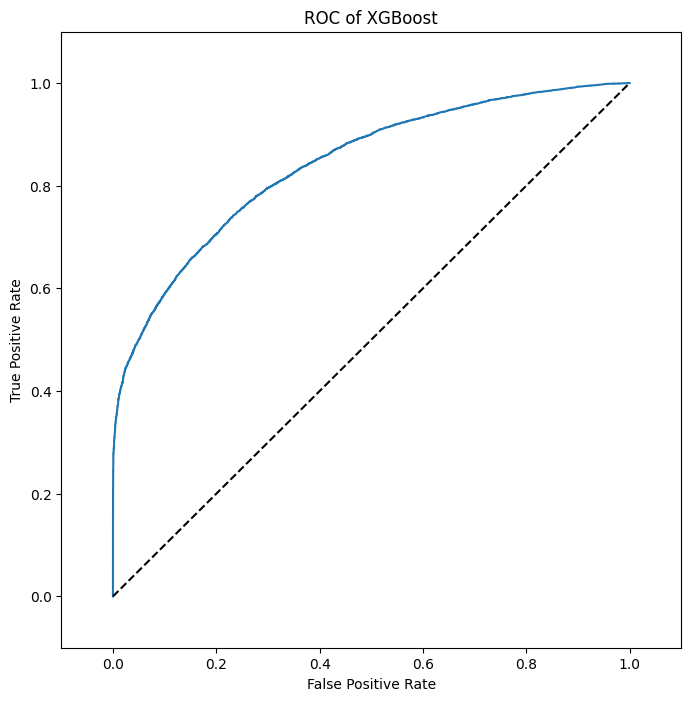

In [ ]:
y_pred_proba = xgb_res['fitted_model'].predict_proba(X_train_xgb)[:,1]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)

# Plot the ROC curve
fig = plt.figure(figsize=(8,8))
plt.title('ROC of XGBoost')

# Plot ROC curve
plt.plot(fpr, tpr)

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

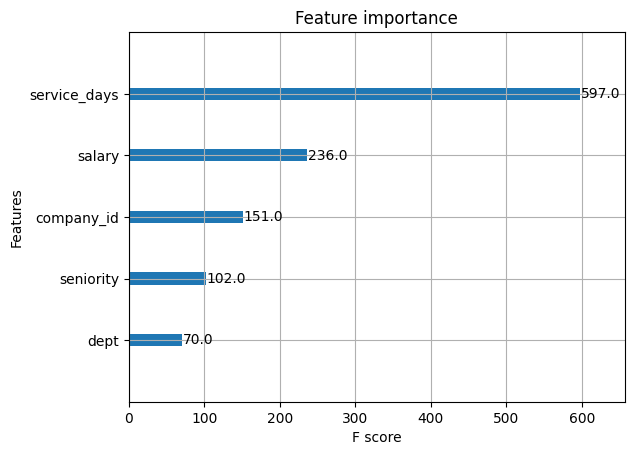

In [ ]:
# xgb_res['fitted_model'].feature_importances_
xgb.plot_importance(xgb_res['fitted_model'])

## Test Performance Evaluation

Based on 5-fold CV on training data with performance metric as ROC AUC. The performance of Logistic Regression, Random Forest, and XGBoost are
* Logistic Regression: 0.62
* Random Forest: 0.82
* XGBoost: 0.83

Thus, the best model is XGBoost. We then evaluate its performance on the testing dataset to see its generalization performance.

In [40]:
# Fit the best model on the entire training dataset
best_model = xgb.XGBClassifier(random_state = 0,
                            objective = 'binary:logistic',
                             n_estimators = 100,
                             eta = 0.1, # learning_rate/step size shrinkage
                              max_depth = 4,  # default = 6
                              min_child_weight = 2, # Minimum sum of instance weight(hessian) needed in a child.
                              reg_lambda = 1, # L2 regularization para
                              alpha = 0.8, # L1 regularization para, default = 0. Not using here since feature dim is not high
                              colsample_bytree = 1,  # feature random sampling fraction for each tree
                           subsample = 1, # data random sampling fraction for each tree
                           importance_type = 'gain',
                           enable_categorical=True
                            )

best_model.fit(X_train_xgb, y_train)

XGBClassifier(alpha=0.8, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=True,
              eta=0.1, eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type='gain',
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [41]:
ytest_pred = best_model.predict(X_test_xgb)
roc_auc_score(y_true = y_test, y_score = ytest_pred)

0.7441999208505294

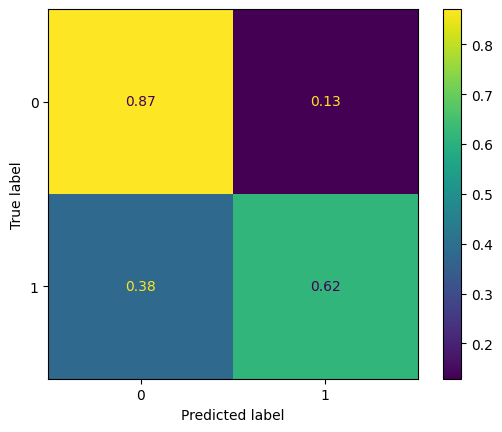

In [ ]:
cm = confusion_matrix(y_test, ytest_pred, normalize = 'true', labels = [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1])
disp.plot()

# Model Interpretation
[API](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.TreeExplainer.html)

[Reference](https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/tree_explainer/Census%20income%20classification%20with%20XGBoost.html)

[Reference 2](https://medium.com/analytics-vidhya/shap-part-3-tree-shap-3af9bcd7cd9b)

* The feature importance under the trained model itself is unstable. The SHAP method is a better and more robust model interpretation method.
* Here we interpret the best model - Random Forest - using SHAP.

Note that SHAP values compute slowly, and we need to pass the entire training data to TreeExplainer.

In [42]:
pip install shap

In [43]:
import shap

In [44]:
# Generate a sample set of the training data with sampling weight = cvr*I(not_converted) + (1-cvr)*I(converted)
data_interp = X_train_xgb.copy()

In [45]:
# For classification problems, explainer.shap_values() return a list of size n_classes.
# Each object of this list is an array of size [n_samples, n_features] and corresponds to the SHAP values for the respective class.
# In this example, shap_values[1] is the SHAP values for the positive class & shap_values[0] is the SHAP values for the negative class.

explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(data_interp_sample, check_additivity = False)
shap_values = explainer.shap_values(X_train_xgb, check_additivity = False)

## Global Interpretation
Due to the size of the training data and the computational intensity of SHAP values, we conduct the 'global' interpretation on the sampled training data.

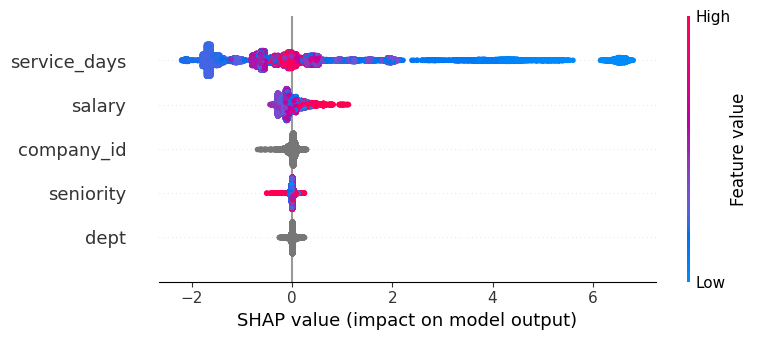

In [ ]:
shap.summary_plot(shap_values, features = X_train_xgb )

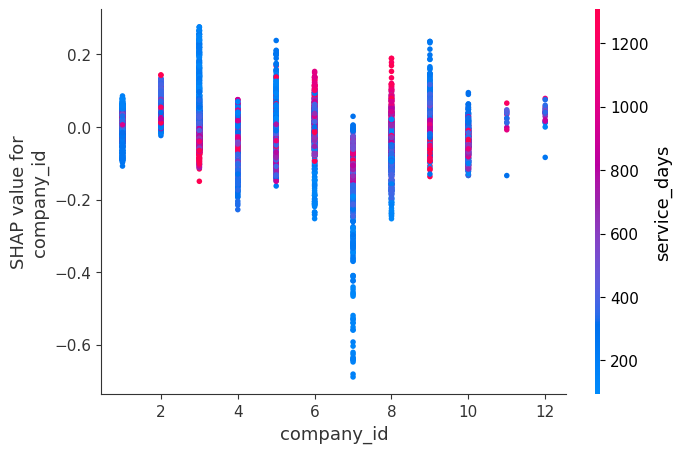

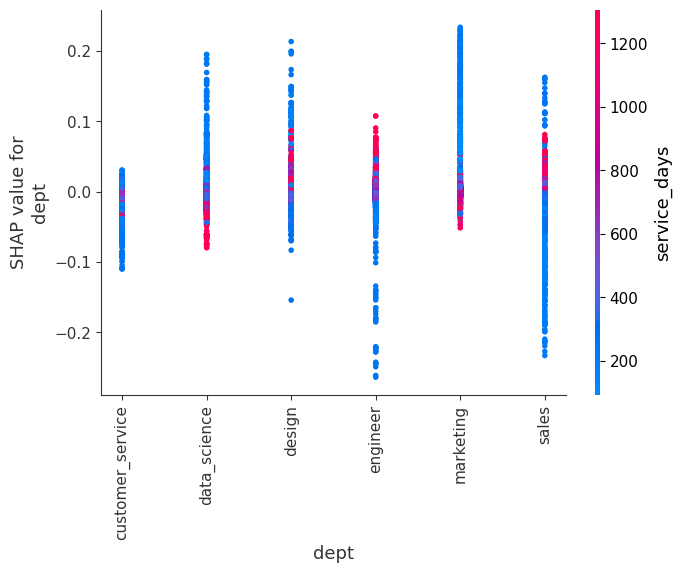

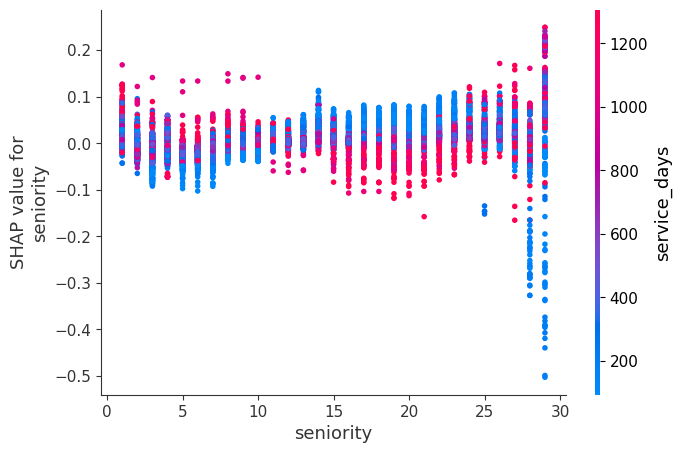

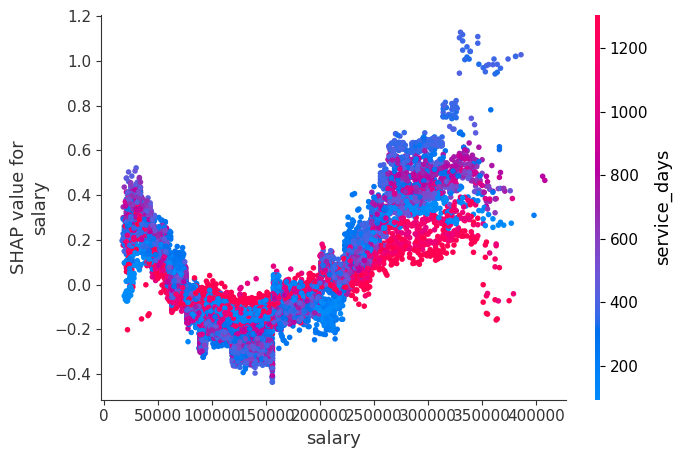

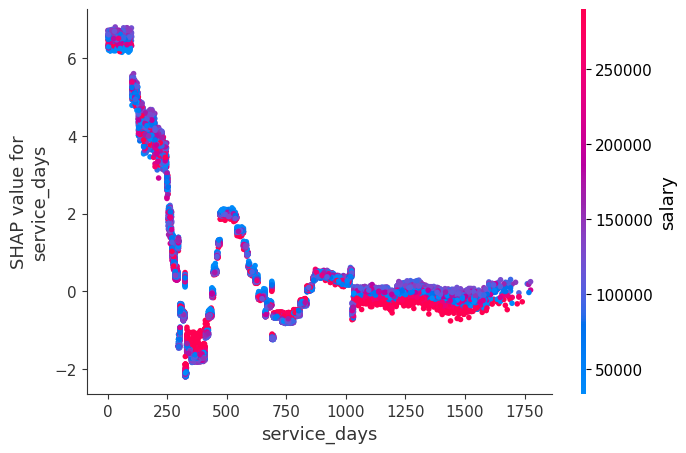

In [ ]:
# SHAP Dependence Plots
# similar to partial dependence plots, but account for the feature interaction effects, and are only defined in regions of the input space
# supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects.

# Not sure why it isn't displaying the original feature scales ...
for name in X_train_xgb.columns:
    shap.dependence_plot(name, shap_values, features =  X_train_xgb, display_features = train_df)

**Findings**
* For employees at data science and marketing department, higher service_days usually means lower retention rate. However, this trend is the opposite for the engineering department.
* There is a 'V' shaped relationship between retention rate and salary. When salary is less than \$150k/yr, retention rate decreases as salary increases; when salary is higher than \$150k/yr, retention rate increases as salary increases. Addtionally, when salary is lower than \$230k/yr, employees with higher service_days have higher retention rate; when salary is higher than \$230k/yr, employees with higher service_days have lower retention rate.
* There is a clear pattern in the relationship between retention rate and service_days. **There are two dips in retention rate at around service days corresponding to 1yr and 2yr, respectively.**

## Local Interpretation

### Visualize a single prediction
* explainer.expected_value[1] means that we are focusing on the convertion rate not non-conversion rate
* shap_values[i][:,1] show the force plot of the ith observation focusing on the convertion rate

In [ ]:
shap.initjs() # print the JS visualization code to the notebook
obs_ind = 0
shap.plots.force(explainer.expected_value, shap_values[obs_ind], features = X_train_xgb.iloc[obs_ind,:])

In [ ]:
shap.initjs() # print the JS visualization code to the notebook
obs_ind = 3
shap.plots.force(explainer.expected_value, shap_values[obs_ind], features = train_df[num_vars+cat_vars].iloc[obs_ind,:])

In [ ]:
shap.initjs() # print the JS visualization code to the notebook
obs_ind = 5
shap.plots.force(explainer.expected_value, shap_values[obs_ind], features = train_df[num_vars+cat_vars].iloc[obs_ind,:])

## Visualize multiple predictions

In [63]:
# plotting is slow. Need to do sampling
train_df_sample = train_df.sample(n = 1000, random_state = 0)

In [67]:
shap.initjs() # print the JS visualization code to the notebook
shap.plots.force(explainer.expected_value, shap_values[list(train_df_sample.index),:], features = train_df_sample[num_vars+cat_vars])

# Insights and Recommendations
Based on the findings in during data EDA and model interpretation sections, I have the following insights and recommendations
* For employees at data science and marketing department, higher service_days usually means lower retention rate. However, this trend is the opposite for the engineering department.

  **Recommendations**
  * Send out questionarires to data science and marketing employees with high service_days and engineers with low service_days to find out why they tend to leave. Example questions can be "Are you happy with your job/manager/salary/colleagues/work-life-balance/growing opportunity, etc?", "In which aspect of your job do you suggest an improvement"
* Overall, there is a 'V' shaped relationship between retention rate and salary. When salary is less than \$150k/yr, retention rate decreases as salary increases; when salary is higher than \$150k/yr, retention rate increases as salary increases. Addtionally, when salary is lower than \$230k/yr, employees with higher service_days have higher retention rate; when salary is higher than \$230k/yr, employees with higher service_days have lower retention rate.

  **Recommendations**
  * For employees with lower income, salary is a primary reason of stay-or-leave. So, the company can strengthen the annual performance review for promotion and bonus for them.
  * For employees with higher income, they might take other factors as a higher priority. Such as, growing opportunity, work-life-balance, etc. Thus, I suggest the company to find out the reasons and try to satify the top-performers's requirement.
* Service_days is the most important feature in predicting the retention rate. Overall, **the higher the service_days, the lower the retention rate**. In addition, there is a clear pattern in the relationship between retention rate and service_days. **There are two sharp drops in retention rate at around service days corresponding to 1yr and 2yr, respectively.**

  **Recommendations**
  * The company should work on keeping the veterans through, e.g. improve their work-life balance, improve their pay and benefits, etc.
  * Employees are mostly likely to leave after their 1st and 2nd anniversaries. Probably because then just got their stock or bonus. Thus, in order to preventing them from leaving, the company could increase their stock share and bonus for the following years, especially for the top-performers.

# Future Works
* **Feature Engineering**: The best model's performance on testing data is not ideal (ROC AUC = 0.74). If we look at out data shape, we can see that we have enough data but we only have 4 features + 1 from feature engineering. Thus, an important area of future work will be further feature engineering. Potential candidate features include employee's performance, historical reviews (self-review and peer-review), historical promotion/salary-raise/bonus, geo-location, education, gender, family status, etc.
* **Employee clustering**: Although, department and company provide natural clusterings, the multi-sample SHAP force plot inspired us to conduct clustering based on SHAP values to better understand employee retention behaviors.